In [7]:
import os 
os.chdir("/home/minasian/PycharmProjects/AutoML")
os.getcwd()
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (11, 5)

Populating the interactive namespace from numpy and matplotlib


In [8]:
import argparse
import os
import numpy as np
import pandas as pd
import pickle
import time
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from examples.baseline.utils import transform_datetime_features
import matplotlib.pyplot as plt

In [9]:
TIME_LIMIT = int(os.environ.get('TIME_LIMIT', 5*60))
ONEHOT_MAX_UNIQUE_VALUES = 20
BIG_DATASET_SIZE = 500 * 1024 * 1024


In [10]:
start_time = time.time()
train_csv="sdsj2018_automl_check_datasets/check_1_r/train.csv"
model_dir="examples/baseline/models"
mode='regression' if train_csv.split("/")[-2].split("_")[-1]=='r' else 'classification'
df = pd.read_csv(train_csv)
df.shape

(365, 42)

In [11]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.2); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.2, mixed mode)
  Starting server from /home/minasian/anaconda3/envs/last/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9jtstzm5
  JVM stdout: /tmp/tmp9jtstzm5/h2o_minasian_started_from_python.out
  JVM stderr: /tmp/tmp9jtstzm5/h2o_minasian_started_from_python.err


H2OServerError: Server process terminated with error code 1

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Import a sample binary outcome train/test set into H2O
# train = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_train_10k.csv")
# test = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_test_5k.csv")

# Identify predictors and response
x = df.columns
y = "target"
x.remove(target)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 30 seconds


In [603]:
df['datetime_0'] =  pd.to_datetime(df['datetime_0'], format='%Y-%m-%d')
df=df.sort_values(by='datetime_0')

## AUTOML 

In [ ]:
aml = H2OAutoML(max_runtime_secs = 30)
aml.train(x = x, y = y,
          training_frame = train)

In [ ]:




# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_train_10k.csv")
test = h2o.import_file("https://s3.amazonaws.com/erin-data/higgs/higgs_test_5k.csv")

In [604]:
df=df.reset_index(drop=True)
df['datetime_0']=[str(i.date())for i in df['datetime_0'].tolist()]

In [605]:
df_y = df.target.copy()
df_X = df.drop('target', axis=1)

is_big = df_X.memory_usage().sum() > BIG_DATASET_SIZE
is_big

True

In [606]:
df_y=np.log(df_y+1)

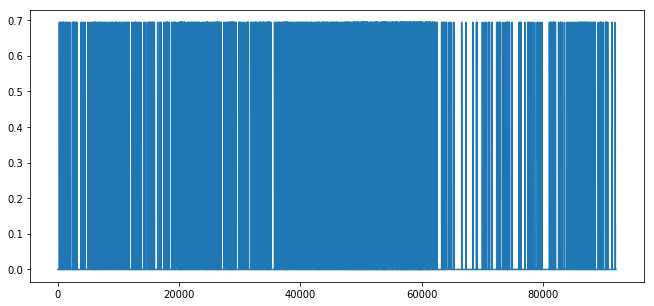

In [607]:
plt.plot(df_y)

In [608]:
# drop constant features
constant_columns = [
    col_name
    for col_name in df_X.columns
    if df_X[col_name].nunique() == 1
    ]
constant_columns

['number_28',
 'number_40',
 'number_91',
 'number_92',
 'number_98',
 'number_102',
 'number_104',
 'number_106',
 'number_107',
 'number_108',
 'number_109',
 'number_110',
 'number_111',
 'number_112',
 'number_113',
 'number_114',
 'number_116',
 'number_117',
 'number_118',
 'number_119',
 'number_120',
 'number_121',
 'number_122',
 'number_123',
 'number_124',
 'number_125',
 'number_126',
 'number_127',
 'number_128',
 'number_129',
 'number_130',
 'number_131',
 'number_132',
 'number_133',
 'number_134',
 'number_135',
 'number_136',
 'number_137',
 'number_138',
 'number_139',
 'number_140',
 'number_141',
 'number_142',
 'number_143',
 'number_144',
 'number_145',
 'number_146',
 'number_147',
 'number_148',
 'number_149',
 'number_150',
 'number_151',
 'number_152',
 'number_213',
 'number_214',
 'number_217',
 'number_218',
 'number_219',
 'number_222',
 'number_224',
 'number_230',
 'number_234',
 'number_236',
 'number_237',
 'number_240',
 'number_245',
 'number_299',


In [609]:
df_X.drop(constant_columns, axis=1, inplace=True)
df_X.shape

(92091, 618)

In [610]:
model_config = {}
model_config['categorical_values'] = {}
model_config['is_big'] = is_big


In [611]:
df_X.shape

(92091, 618)

In [612]:
if is_big:
    # missing values
    if any(df_X.isnull()):
        model_config['missing'] = True
        df_X.fillna(-1, inplace=True)

    new_feature_count = min(df_X.shape[1],
                            int(df_X.shape[1] / (df_X.memory_usage().sum() / BIG_DATASET_SIZE)))
    # take only high correlated features
    correlations = np.abs([
        np.corrcoef(df_y, df_X[col_name])[0, 1]
        for col_name in df_X.columns if col_name.startswith('number')
        ])
    new_columns = df_X.columns[np.argsort(correlations)[-new_feature_count:]]
    df_X = df_X[new_columns]

else:
    # features from datetime
    df_X = transform_datetime_features(df_X)

    # categorical encoding
    categorical_values = {}
    for col_name in list(df_X.columns):
        col_unique_values = df_X[col_name].unique()
        if 2 < len(col_unique_values) <= ONEHOT_MAX_UNIQUE_VALUES:
            categorical_values[col_name] = col_unique_values
            for unique_value in col_unique_values:
                df_X['onehot_{}={}'.format(col_name, unique_value)] = (df_X[col_name] == unique_value).astype(int)
    model_config['categorical_values'] = categorical_values

    # missing values
    if any(df_X.isnull()):
        model_config['missing'] = True
        df_X.fillna(-1, inplace=True)

In [613]:
df_X.head()


,number_694,number_15,number_703,number_36,number_17,number_29,number_0,number_342,number_166,number_743,...,number_87,number_752,number_709,number_225,number_343,number_717,number_713,number_710,number_220,number_101
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.00,-2.0,-1.00,...,1.0,30.0,0.0,-1.0,-1.00,-1.0,-1.0,0.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,36422.87,507000.0,0.00,...,1.0,11.0,0.0,-1.0,861871.35,-1.0,-1.0,0.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.00,1000000.0,0.33,...,1.0,5.0,0.0,-1.0,1189794.56,-1.0,-1.0,0.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.00,-2.0,-1.00,...,1.0,22.0,0.0,-1.0,-1.00,-1.0,-1.0,0.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-2.00,-2.0,1.00,...,1.0,23.0,0.0,-1.0,-1.00,-1.0,-1.0,0.0,-1.0,-1.0


In [614]:
print(df_X.shape)

(92091, 611)


In [615]:
used_columns = [
    col_name
    for col_name in df_X.columns
    if col_name.startswith('number') or col_name.startswith('onehot')
    ]
df_X = df_X[used_columns].values
model_config['used_columns'] = used_columns

In [616]:
model_config['mode']=mode
model_config.keys()
# model_config

dict_keys(['categorical_values', 'is_big', 'missing', 'used_columns', 'mode'])

In [596]:
scaler = StandardScaler(copy=False)
df_X = scaler.fit_transform(df_X)

In [597]:
if mode == 'regression':
    model = Ridge()
else:
    model = LogisticRegression()

In [598]:
model.fit(df_X, df_y)
model_config['model'] = model

ValueError: Unknown label type: 'continuous'

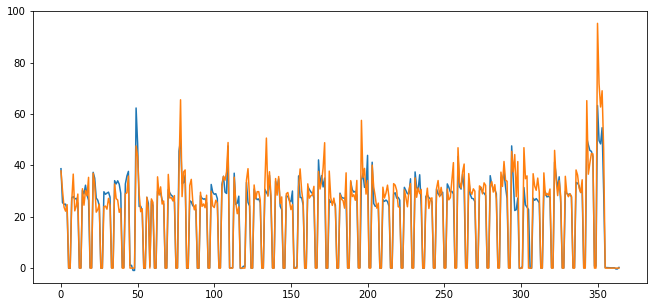

In [573]:
y_hat=model.predict(df_X)
y_true=df_y
plt.plot(np.exp(y_hat)-1)
plt.plot(df.target)

In [574]:
from sklearn.metrics import mean_squared_error

In [576]:
model_config_filename = os.path.join(model_dir, 'model_config.pkl')
mean_squared_error(df.target,np.exp(model.predict(df_X)))   

25.75882656355881

In [577]:
with open(model_config_filename, 'wb') as fout:
    pickle.dump(model_config, fout, protocol=pickle.HIGHEST_PROTOCOL)